This notebook aims to provide a quantification of the Actions (and their releases) from the dataset, as well as some insights about the release frequency of Actions and the evolution of this frequency through time. It also provides insight on how frequently workflows are updated in repositories using GHA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn
import lifelines

In [2]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-08-31')
REL_CENSOR = pd.to_datetime('2018-10-16')  # Limited public beta of GHA

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

### Load data

In [3]:
# Releases of Actions
df_releases = (
    pd.read_csv('../data/releases.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date, errors='coerce').dt.tz_convert(None))
    .rename(columns={'release': 'version'})
    [lambda d: d.date.between(REL_CENSOR, DATE_RANGE[1], inclusive='both')]
    [['owner', 'repo', 'version', 'date']]
)

In [4]:
# Updates of workflows
df_workflows = (
    pd.read_csv('../data/workflow_files.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date))
    [['repository', 'date', 'filename', 'workflow']]
)

### Data overview

#### Evolution of the number of Actions and releases

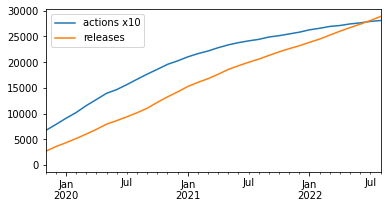

In [5]:
fig, ax = matplotlib.pyplot.subplots()
# fig.set_size_inches(FIG_SIZE)

temp = (
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .merge(
        df_releases.sort_values('date', ascending=True).assign(releases=lambda d: range(1, len(d) + 1)),
        how='right',
        on=['owner', 'repo', 'date'],
    )
    [['date', 'owner', 'repo', 'actions', 'releases']]
    .fillna(method='ffill')
    .groupby(pd.Grouper(key='date', freq='M'))
    .max()
)

(
    temp
    [['actions', 'releases']]
    .assign(actions=lambda d: d.actions * 10)
    .rename(columns={'actions': 'actions x10'})
    .plot(ax=ax, color=PALETTE)
)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel=None
)

savefig(fig, 'rel_evolution')

In [6]:
display(temp[lambda d: d.index >= DATE_RANGE[0]].iloc[0])
display(temp.iloc[-1])

owner       zwaldowski
repo                yq
actions          669.0
releases          2634
Name: 2019-11-30 00:00:00, dtype: object

owner              zricethezav
repo        zola-deploy-action
actions                 2811.0
releases                 28889
Name: 2022-08-31 00:00:00, dtype: object

#### Monthly number of releases

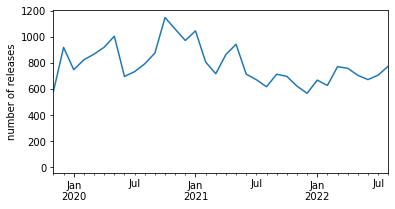

In [7]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(releases=('version', 'count'))
)

temp['releases'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of releases',
)

savefig(fig, 'rel_monthly_number')

In [8]:
temp.describe()

,releases
count,47.000000
mean,614.659574
std,327.628188
min,12.000000
25%,567.500000
50%,706.000000
75%,816.500000
max,1149.000000


#### Monthly proportion of Actions being updated

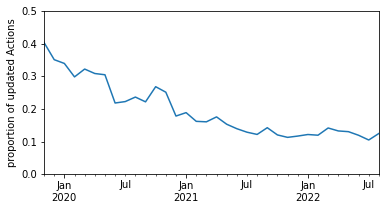

In [9]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg({'actions': 'max'})
    .merge(
        df_releases
        .assign(repository=lambda d: d.owner + '/' + d.repo)
        .groupby(pd.Grouper(key='date', freq='M'))
        .agg(updated=('repository', 'nunique')),
        how='outer',
        left_index=True,
        right_index=True,
    )
    .assign(proportion=lambda d: d['updated'] / d['actions'])
)

temp['proportion'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylim=(0, 0.5), 
    ylabel='proportion of updated Actions'
)

savefig(fig, 'rel_prop_updated')

In [10]:
temp.iloc[-1]

actions       2811.000000
updated        351.000000
proportion       0.124867
Name: 2022-08-31 00:00:00, dtype: float64

#### Evolution of the number of repositories using GHA

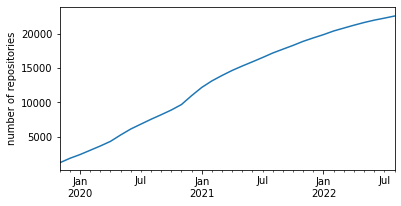

In [11]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_workflows
    .sort_values('date', ascending=True)
    .drop_duplicates('repository', keep='first')
    .assign(repositories=lambda d: range(1, len(d) + 1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg({'repositories': 'max'})
)

temp['repositories'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of repositories',
)

savefig(fig, 'workflow_repository_number')

In [12]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
repositories,35.0,13327.171429,7044.768983,1237.0,7199.5,14644.0,19603.0,22758.0


#### Evolution of the number of workflow updates

A workflow update is detected by comparing the hash value of a workflow file with the hash value for the same workflow file in the previous snapshot. Newly introduced workflows are also considered as updates. 

In [13]:
# Let's store this dataframe since it will be used in many of the following cells.
data = (
    df_workflows
    .sort_values(['repository', 'filename', 'date'])
    .assign(workflow_previous=lambda d: d.workflow.shift(1))
    # Since we applied shift on all repositories/date, let's remove the extra ones. 
    .assign(workflow_previous=lambda d: d.workflow_previous.where(d[['repository', 'filename']].duplicated(), np.nan))
    .assign(updated=lambda d: d.workflow != d.workflow_previous)
)

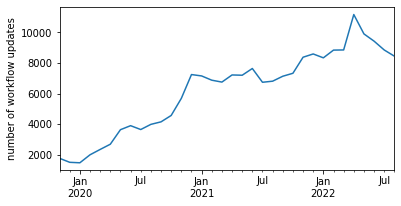

In [14]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(updates=('updated', 'sum'))
)

temp['updates'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of workflow updates',
)

savefig(fig, 'workflow_monthly_updates')

#### Monthly proportion of repositories updating a workflow file

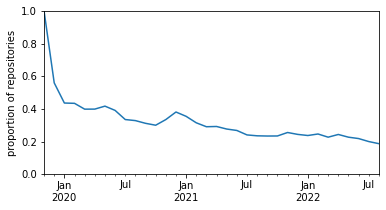

In [15]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .sort_values(['date', 'repository'])
    .assign(repositories=lambda d: (~d['repository'].duplicated()).cumsum())
    [lambda d: d.updated]
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        updated=('repository', 'nunique'),
        repositories=('repositories', 'max'),
    )
    .assign(proportion=lambda d: d.updated / d.repositories)
)

temp['proportion'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of repositories',
    ylim=(0, 1)
)

savefig(fig, 'workflow_prop_repo_updated')

#### Combining monthly proportion of updated actions/updated repositories

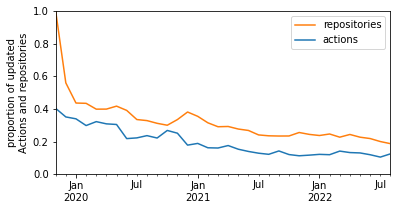

In [16]:
fig, ax = matplotlib.pyplot.subplots()

# Code taken from the above cell
(
    data
    .sort_values(['date', 'repository'])
    .assign(repositories=lambda d: (~d['repository'].duplicated()).cumsum())
    [lambda d: d.updated]
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        updated=('repository', 'nunique'),
        repositories=('repositories', 'max'),
    )
    .assign(repositories=lambda d: d.updated / d.repositories)
    [['repositories']]
    .plot(ax=ax, color=PALETTE[1])
)

# Code taken from a cell above
(
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg({'actions': 'max'})
    .merge(
        df_releases
        .assign(repository=lambda d: d.owner + '/' + d.repo)
        .groupby(pd.Grouper(key='date', freq='M'))
        .agg(updated=('repository', 'nunique')),
        how='outer',
        left_index=True,
        right_index=True,
    )
    .assign(actions=lambda d: d['updated'] / d['actions'])
    [['actions']]
    .plot(ax=ax, color=PALETTE[0])
)


ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylim=(0, 1), 
    ylabel='proportion of updated\nActions and repositories'
)

savefig(fig, 'prop_updated_both')

### Release frequency

#### Distribution of the number of releases

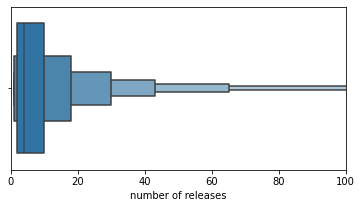

In [17]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .groupby(['owner', 'repo'], as_index=False)
    .agg(releases=('version', 'count'))   
)

seaborn.boxenplot(
    data=temp,
    orient='h',
    palette=PALETTE,
    ax=ax,
)

ax.set_yticklabels([])

ax.set(
    xlabel='number of releases',
    xlim=(0, 100),
    ylabel=None,
)
       
savefig(fig, 'rel_distribution_number')

In [18]:
temp.releases.describe()

count    2811.000000
mean       10.277126
std        31.201441
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max      1074.000000
Name: releases, dtype: float64

#### Same analysis, but different visualization

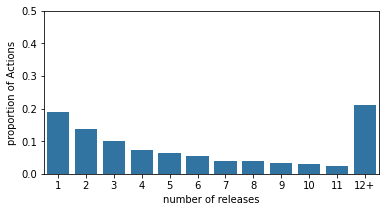

In [19]:
fig, ax = matplotlib.pyplot.subplots()

threshold = 12

temp = (
    df_releases
    .groupby(['owner', 'repo'], as_index=False)
    .agg(releases=('version', 'count'))
    .assign(releases=lambda d: np.where(d.releases < threshold, d.releases, f'{threshold}+'))
    .groupby('releases', as_index=False)
    .agg(actions=('repo', 'count'))
    .assign(prop=lambda d: d.actions / d.actions.sum())
)
        
seaborn.barplot(
    x='releases',
    y='prop',
    order=list(map(str, range(1, threshold))) + [f'{threshold}+'],
    data=temp,
    color=PALETTE[0],
    ax=ax,
)
        
ax.set(
    xlabel='number of releases',
    ylabel='proportion of Actions',
    ylim=(0, 0.50),
)
       
savefig(fig, 'rel_distribution_number_variant')

In [20]:
temp.set_index('releases').loc[list(map(str, range(1, threshold))) + [f'{threshold}+']].T

releases,1,2,3,4,5,6,7,8,9,10,11,12+
actions,535.000000,382.000000,286.000000,205.000000,176.000000,156.000000,112.000000,114.000000,94.00000,84.000000,70.000000,597.00000
prop,0.190324,0.135895,0.101743,0.072928,0.062611,0.055496,0.039843,0.040555,0.03344,0.029883,0.024902,0.21238


#### Distribution of the time since last update

In [21]:
# Let's store this dataframe since it will be used in many cells.
data = (
    df_releases
    .sort_values(['owner', 'repo', 'date'])
    .assign(updated=lambda d: d.date.shift(-1))
    # Since we applied shift on all actions/date, let's remove the extra ones. 
    .assign(updated=lambda d: d.updated.where(d[['owner', 'repo']].duplicated(keep='last'), np.nan))
    .assign(duration=lambda d: d.updated.fillna(d.date.max()) - d.date)
)

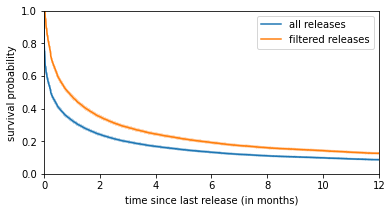

In [22]:
fig, ax = matplotlib.pyplot.subplots()

kmf = lifelines.KaplanMeierFitter()
_ = data
kmf.fit(_.duration / pd.to_timedelta('30 days'), ~_.updated.isnull(), label='all releases')
kmf.plot(legend=True, color=PALETTE[0], ax=ax)

# Excluding releases made within 24 hours: 
_ = data[lambda d: d.duration >= pd.to_timedelta('1 day')]
kmf.fit(_.duration / pd.to_timedelta('30 days'), ~_.updated.isnull(), label='filtered releases')
kmf.plot(legend=True, color=PALETTE[1], ax=ax)

ax.set(
    xlabel='time since last release (in months)', 
    xlim=(0, 12),
    ylabel='survival probability',
    ylim=(0, 1),
)

savefig(fig, 'rel_survival')

In [23]:
kmf.survival_function_at_times(range(0, 13))

0     1.000000
1     0.475087
2     0.349930
3     0.285029
4     0.243631
5     0.214076
6     0.191342
7     0.173091
8     0.159770
9     0.150324
10    0.141929
11    0.132316
12    0.125453
Name: filtered releases, dtype: float64